In [112]:
import numpy as np
import pandas as pd
import os
import glob
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import yfinance as yf

In [113]:
DATA_PATH    = 'downloader-data'
TICKERS_PATH = 'tickers'

## 1 - data collection

### read tickers

In [114]:
ticker_files = glob.glob(f'{TICKERS_PATH}/*')
ticker_dfs = []
for tf in ticker_files[1:]:
    ticker_dfs.append(pd.read_csv(tf))

tickers = pd.concat(ticker_dfs, ignore_index=True)


### read data

In [115]:
data_for_ticker = {}
for index, (ticker, name) in tickers.iterrows():
    try:
        df = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
        if len(df) > 100:
            data_for_ticker[ticker] = df
    except:
        pass
    
print(data_for_ticker['AAPL'])

           Date       Close     Volume
0    2020-10-27  116.599998   92276800
1    2020-10-28  111.199997  143937800
2    2020-10-29  115.320000  146129200
3    2020-10-30  108.860001  190272600
4    2020-11-02  108.769997  122866900
..          ...         ...        ...
248  2021-10-21  149.479996   61421000
249  2021-10-22  148.690002   58839600
250  2021-10-25  148.639999   50720600
251  2021-10-26  149.320007   60893400
252  2021-10-27  148.850006   55951800

[253 rows x 3 columns]


## 2 - assets map

In [116]:
for ticker, data in data_for_ticker.items():
    data_for_ticker[ticker] = data.assign(logret=np.log(data.Close).diff())
    data_for_ticker[ticker]['minus_logret'] = data_for_ticker[ticker]['logret'].mul(-1)

In [117]:
data_for_ticker['AAPL']

Date       Close     Volume    logret  minus_logret
0    2020-10-27  116.599998   92276800       NaN           NaN
1    2020-10-28  111.199997  143937800 -0.047419      0.047419
2    2020-10-29  115.320000  146129200  0.036381     -0.036381
3    2020-10-30  108.860001  190272600 -0.057648      0.057648
4    2020-11-02  108.769997  122866900 -0.000827      0.000827
..          ...         ...        ...       ...           ...
248  2021-10-21  149.479996   61421000  0.001473     -0.001473
249  2021-10-22  148.690002   58839600 -0.005299      0.005299
250  2021-10-25  148.639999   50720600 -0.000336      0.000336
251  2021-10-26  149.320007   60893400  0.004564     -0.004564
252  2021-10-27  148.850006   55951800 -0.003153      0.003153

[253 rows x 5 columns]

### compute logret_mean, logret_std

In [118]:
estims = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
estims.set_index('ticker', inplace=True)

for ticker, data in data_for_ticker.items():
    estims.loc[ticker] = [data['logret'].mean(), data['logret'].std()]
    
estims

logret_mean  logret_std
ticker                         
AAIT       0.002652    0.023450
AAL        0.002093    0.031258
AAME       0.002481    0.070508
AAOI      -0.001026    0.036126
AAON       0.000559    0.016321
...             ...         ...
UPRO       0.003376    0.024899
LIFE       0.003917    0.064695
FLOT       0.000009    0.000302
AQUA       0.002118    0.023276
INGR       0.000886    0.015232

[1953 rows x 2 columns]

### plot the map

In [119]:
import plotly.express as px
from sklearn.preprocessing import normalize

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig.show()

In [120]:
ticker_colour.sort_values(ascending=False)
portfolio = ticker_colour.sort_values(ascending=False)[:50]
tickers = portfolio.keys()
tickers = list(tickers)
print(len(tickers))
tickers

50


['PRFT',
 'ANAT',
 'III',
 'WIRE',
 'OFS',
 'DXLG',
 'PMBC',
 'FTNT',
 'CG',
 'GAIN',
 'SBNY',
 'TGA',
 'TRNS',
 'AAVAS',
 'PDBC',
 'JYNT',
 'CRAI',
 'CSWC',
 'ARLP',
 'UHAL',
 'ADANIGREEN',
 'JCOM',
 'ATLC',
 'ORMP',
 'NYMTP',
 'CBNK',
 'GOOG',
 'TBBK',
 'TGLS',
 'HMNF',
 'ANGO',
 'PNNT',
 'COMT',
 'ARCC',
 'GOOGL',
 'HMHC',
 'OMCL',
 'SFBS',
 'LPLA',
 'VNOM',
 'NDAQ',
 'RDVY',
 'CAR',
 'SLCT',
 'GLAD',
 'WVVI',
 'SIVB',
 'BRKR',
 'CRVL',
 'PFLT']

In [121]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers[0]]['Date'][1:]

for ticker in tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['Close'][1:]
    
joint_data = joint_data.dropna()
del joint_data['Date']
joint_data


PRFT        ANAT   III        WIRE    OFS  DXLG   PMBC        FTNT  \
1     38.759998   68.000000  2.03   45.939999   4.06  0.27   3.72  118.949997   
2     38.419998   69.070000  2.03   46.169998   4.01  0.27   3.72  118.000000   
3     39.160000   68.800003  2.05   46.209999   3.97  0.26   3.71  110.370003   
4     40.150002   70.589996  2.09   47.180000   4.05  0.26   3.86  110.589996   
5     41.950001   72.290001  2.13   47.639999   4.02  0.27   4.17  112.410004   
..          ...         ...   ...         ...    ...   ...    ...         ...   
240  120.900002  189.490005  7.47  102.980003  10.53  5.57  10.04  306.799988   
241  123.820000  190.050003  7.52  103.739998  10.60  5.87  10.02  306.579987   
242  126.339996  189.449997  7.49  103.370003  10.52  5.89   9.95  310.100006   
243  129.880005  189.259995  7.43  107.730003  10.84  5.91   9.71  313.809998   
244  128.800003  189.020004  7.25  110.690002  11.01  6.13   9.51  315.290009   

            CG   GAIN  ...        NDAQ       RDVY         CAR       SLCT  \
1    25.160000   8.33  ...  121.730003  31.969000   35.160000   7.280000   
2    25.559999   8.20  ...  122.010002  32.458000   36.700001   7.730000   
3    24.920000   8.33  ...  120.989998  32.250000   33.669998   7.450000   
4    25.389999   8.49  ...  123.180000  32.806999   30.520000   7.790000   
5    25.340000   8.56  ...  124.910004  33.610001   30.570000   8.070000   
..         ...    ...  ...         ...        ...         ...        ...   
240  48.900002  14.15  ...  197.679993  48.590000  142.429993  20.299999   
241  49.270000  14.18  ...  197.479996  48.430000  153.389999  20.320000   
242  49.849998  14.53  ...  197.419998  48.439999  149.860001  19.650000   
243  51.290001  14.55  ...  200.639999  49.470001  147.190002  19.350000   
244  51.450001  14.71  ...  203.020004  49.860001  150.970001  18.879999   

      GLAD   WVVI        SIVB       BRKR        CRVL   PFLT  
1     7.03   6.17  278.540009  41.240002   90.290001   7.84  
2     7.18   6.18  282.070007  41.990002   91.449997   7.90  
3     7.31   6.11  290.700012  42.540001   91.220001   7.80  
4     7.35   6.16  306.980011  44.029999   92.500000   8.06  
5     7.26   6.10  310.570007  43.980000   86.260002   8.10  
..     ...    ...         ...        ...         ...    ...  
240  11.38  14.66  666.510010  76.239998  167.869995  13.28  
241  11.33  14.50  659.090027  75.540001  170.240005  13.33  
242  11.33  14.45  667.719971  74.849998  168.970001  13.28  
243  11.38  14.69  683.890015  76.309998  172.070007  13.28  
244  11.43  14.76  690.330017  77.230003  174.679993  13.18  

[244 rows x 50 columns]

In [122]:
#Годовая доходность
mu = expected_returns.mean_historical_return(joint_data) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(joint_data)

import matplotlib.pyplot as plt

uniform_logret_std = 0    
uniform_logret_mean = 0
uniform_weight = 1/50
for i in range(len(tickers)):
    uniform_logret_mean += uniform_weight * mu.loc[tickers[i]]
    for j in range(len(tickers)):
        uniform_logret_std += uniform_weight * uniform_weight * Sigma.loc[tickers[i], tickers[j]]       

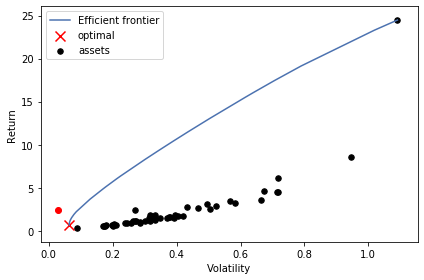

In [123]:
ef_no_shorts = CLA(mu, Sigma, weight_bounds=(0,1))

minvol_ef = ef_no_shorts.min_volatility()
minvol_ef_pwt = ef_no_shorts.clean_weights()


ef_plt_no_shorts = efficient_frontier_no_shorts = pplt.plot_efficient_frontier(ef_no_shorts, showfig = False)
ef_plt_no_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

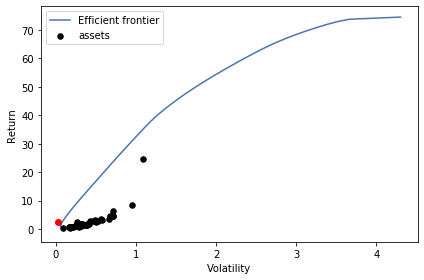

In [124]:
ef_shorts = EfficientFrontier(mu, Sigma, weight_bounds=(-1,1))

#minvol_shorts_ef_shorts = ef_shorts.min_volatility()
#minvol_shorts_ef_shorts_pwt = ef_shorts.clean_weights()

#critical_line_shorts = CLA(mu, Sigma, weight_bounds=(-1,1))

#minvol_cl_shorts = critical_line_shorts.min_volatility()
#minvol_cl_shorts_pwt = critical_line_shorts.clean_weights()

ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

### Portfolios with short sales

In [125]:
import random

def getRandomWeights(n, shorts=False):
    left, right = 0, 100    
    if shorts:
        left = -100     
    weights = [random.randint(left, right) for i in range(0, n)]
    weights = [weight/sum(map(abs, weights)) for weight in weights]
    return weights
    
n_tickers = 50
n_samples = 2000

samples = pd.DataFrame(data=[], columns=['mean', 'std', 'weights'])

for k in range(0, n_samples):
    weights = getRandomWeights(n=n_tickers, shorts=True)

    portfolio_mean = 0    
    portfolio_std = 0
    for i in range(len(tickers)):
        portfolio_mean += weights[i] * mu.loc[tickers[i]]
        for j in range(len(tickers)):
            portfolio_std += weights[i] * weights[j] * Sigma.loc[tickers[i], tickers[j]]
            
    samples.loc[k] = [portfolio_mean, portfolio_std, weights]       
              

In [126]:
import plotly.express as px
from sklearn.preprocessing import normalize

sample_colour = samples['mean'] / samples['std']
sample_size = (sample_colour - sample_colour.min()) / sample_colour.max()
fig = px.scatter(samples, x=samples['std'], y=samples['mean'],
                 hover_name=samples.weights, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=sample_colour)

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.show()

###  Portfolios without shorts sales

In [127]:
n_tickers = 50
n_samples = 1000

samples = pd.DataFrame(data=[], columns=['mean', 'std', 'weights'])

for k in range(0, n_samples):
    weights = getRandomWeights(n=n_tickers, shorts=False)

    portfolio_mean = 0    
    portfolio_std = 0
    for i in range(len(tickers)):
        portfolio_mean += weights[i] * mu.loc[tickers[i]]
        for j in range(len(tickers)):
            portfolio_std += weights[i] * weights[j] * Sigma.loc[tickers[i], tickers[j]]
            
    samples.loc[k] = [portfolio_mean, portfolio_std, weights]       
              

In [128]:
import plotly.express as px
from sklearn.preprocessing import normalize

sample_colour = samples['mean'] / samples['std']
sample_size = (sample_colour - sample_colour.min()) / sample_colour.max()
fig = px.scatter(samples, x=samples['std'], y=samples['mean'],
                 hover_name=samples.weights, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=sample_colour)

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.show()